In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time
import os

import nba_api
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import commonallplayers as cap

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from mar_designs import tidy_axes

In [8]:
# Variables for the notebook
facecolor = "#F7F5F2"
figsize=(11,6)
subplotFigsize=(28,6)
titlesize=16
labelsize=14

pd.set_option('display.max_columns', None)

## Look at all endpoints in nba_api.stats

In [6]:
# help(nba_api.stats.endpoints)

## $\bf{All\space time\space leaders}$ endpoint

In [4]:
import nba_api.stats.endpoints.alltimeleadersgrids as atlg

In [5]:
# Request endpoint and get data into a large dictionary
allTimes = atlg.AllTimeLeadersGrids()
data = allTimes.get_dict()

In [6]:
# Print categories of leaders
allTimeDicts = data["resultSets"]
for i, d in enumerate(allTimeDicts):
    print(i, d["name"])

0 GPLeaders
1 PTSLeaders
2 ASTLeaders
3 STLLeaders
4 OREBLeaders
5 DREBLeaders
6 REBLeaders
7 BLKLeaders
8 FGMLeaders
9 FGALeaders
10 FG_PCTLeaders
11 TOVLeaders
12 FG3MLeaders
13 FG3ALeaders
14 FG3_PCTLeaders
15 PFLeaders
16 FTMLeaders
17 FTALeaders
18 FT_PCTLeaders


In [7]:
# Points scored
pointsLeadersIDs = [l[0] for l in allTimeDicts[1]["rowSet"]]

allTimeDicts[1]

{'name': 'PTSLeaders',
 'headers': ['PLAYER_ID', 'PLAYER_NAME', 'PTS', 'PTS_RANK', 'IS_ACTIVE_FLAG'],
 'rowSet': [[2544, 'LeBron James', 41995, 1, 'Y'],
  [76003, 'Kareem Abdul-Jabbar', 38387, 2, 'N'],
  [252, 'Karl Malone', 36928, 3, 'N'],
  [977, 'Kobe Bryant', 33643, 4, 'N'],
  [893, 'Michael Jordan', 32292, 5, 'N'],
  [1717, 'Dirk Nowitzki', 31560, 6, 'N'],
  [76375, 'Wilt Chamberlain', 31419, 7, 'N'],
  [201142, 'Kevin Durant', 30537, 8, 'Y'],
  [406, "Shaquille O'Neal", 28596, 9, 'N'],
  [2546, 'Carmelo Anthony', 28289, 10, 'N']]}

In [8]:
# Assists made
assistsLeadersIDs = [l[0] for l in allTimeDicts[2]["rowSet"]]

allTimeDicts[2]

{'name': 'ASTLeaders',
 'headers': ['PLAYER_ID', 'PLAYER_NAME', 'AST', 'AST_RANK', 'IS_ACTIVE_FLAG'],
 'rowSet': [[304, 'John Stockton', 15806, 1, 'N'],
  [101108, 'Chris Paul', 12444, 2, 'Y'],
  [467, 'Jason Kidd', 12091, 3, 'N'],
  [2544, 'LeBron James', 11534, 4, 'Y'],
  [959, 'Steve Nash', 10335, 5, 'N'],
  [349, 'Mark Jackson', 10334, 6, 'N'],
  [77142, 'Magic Johnson', 10141, 7, 'N'],
  [600015, 'Oscar Robertson', 9887, 8, 'N'],
  [201566, 'Russell Westbrook', 9885, 9, 'Y'],
  [78318, 'Isiah Thomas', 9061, 10, 'N']]}

In [9]:
# Merge lists and remove duplicates
leaderIDs = list(set(assistsLeadersIDs + pointsLeadersIDs))

In [10]:
# Rebound leaders
allTimeDicts[6]

{'name': 'REBLeaders',
 'headers': ['PLAYER_ID', 'PLAYER_NAME', 'REB', 'REB_RANK', 'IS_ACTIVE_FLAG'],
 'rowSet': [[76375, 'Wilt Chamberlain', 23924, 1, 'N'],
  [78049, 'Bill Russell', 21620, 2, 'N'],
  [76003, 'Kareem Abdul-Jabbar', 17440, 3, 'N'],
  [76979, 'Elvin Hayes', 16279, 4, 'N'],
  [77449, 'Moses Malone', 16212, 5, 'N'],
  [1495, 'Tim Duncan', 15091, 6, 'N'],
  [252, 'Karl Malone', 14968, 7, 'N'],
  [305, 'Robert Parish', 14715, 8, 'N'],
  [708, 'Kevin Garnett', 14662, 9, 'N'],
  [2730, 'Dwight Howard', 14627, 10, 'N']]}

In [11]:
# Field goals made leaders
allTimeDicts[8]

{'name': 'FGMLeaders',
 'headers': ['PLAYER_ID', 'PLAYER_NAME', 'FGM', 'FGM_RANK', 'IS_ACTIVE_FLAG'],
 'rowSet': [[76003, 'Kareem Abdul-Jabbar', 15837, 1, 'N'],
  [2544, 'LeBron James', 15420, 2, 'Y'],
  [252, 'Karl Malone', 13528, 3, 'N'],
  [76375, 'Wilt Chamberlain', 12681, 4, 'N'],
  [893, 'Michael Jordan', 12192, 5, 'N'],
  [977, 'Kobe Bryant', 11719, 6, 'N'],
  [406, "Shaquille O'Neal", 11330, 7, 'N'],
  [1717, 'Dirk Nowitzki', 11169, 8, 'N'],
  [76979, 'Elvin Hayes', 10976, 9, 'N'],
  [165, 'Hakeem Olajuwon', 10749, 10, 'N']]}

## Use $\bf{common\space all\space players}$ endpoint to get IDs of all active players

In [13]:
allPlayers = cap.CommonAllPlayers()
data = allPlayers.get_dict()

In [14]:
activePlayerIDs = []
allPlayers = data["resultSets"][0]
for i, playerRow in enumerate(allPlayers["rowSet"]):
    
    # Check that they're active
    if playerRow[5] == "2024":
        # print(i, playerRow)
        activePlayerIDs.append(playerRow[0])

In [15]:
# Remove players IDs from activePlayerIDs if they're in leadersIDs
activePlayerIDs2 = list(set(activePlayerIDs) - set(leaderIDs))
len(leaderIDs)

19

## Now that I have two lists: `activePlayerIDs2` and  `leaderIDs`, I can see if there are groupings based on points versus assists using $\bf{player\space career\space stats}$ endpoint.

In [ ]:
# Get minutes, points, assists of all in the leadersIDs list
minutesPointsAssistsLeaders = []
for i, ID in enumerate(leaderIDs):
    career = playercareerstats.PlayerCareerStats(player_id=ID) 
    careerDF = career.get_data_frames()[0]
    minutesPointsAssistsLeaders.append(careerDF[["MIN", "PTS", "AST"]].sum().to_numpy())
    time.sleep(10)
    print(i)


In [27]:
ID

1630590

In [ ]:
# Get minutes, points, assists of all active players not in the leadersIDs list
allPlayersSimple = players.get_players()

for i, ID in enumerate(activePlayerIDs):
    career = playercareerstats.PlayerCareerStats(player_id=ID) 
    dfCareer = career.get_data_frames()[0]
    
    # Get name of player with ID. If list is empty, pass and move on. 
    listName = [row["full_name"] for row in allPlayersSimple if row["id"] == ID]
    if listName:
        name = listName[0].replace(" ", "_")
        dfCareer.to_csv(f"../data/playerCareerStats/{name}.csv")
        
    time.sleep(5)



In [47]:
minutesPointsAssists = []
path = "../data/playerCareerStats/"
for playerSheet in os.listdir(path):
    
    if playerSheet !=  ".ipynb_checkpoints":
        
        dfCareer = pd.read_csv(os.path.join(path, playerSheet), usecols=['MIN', 'PTS', 'AST'])
        minutesPointsAssists.append(dfCareer[["MIN", "PTS", "AST"]].sum().to_numpy())


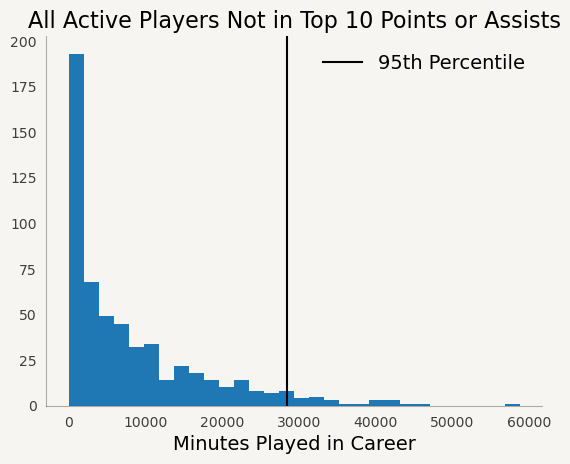

In [53]:
# Get points and assists from top 10% of non leaders
minutes = [sublist[0] for sublist in minutesPointsAssists]
threshold = np.percentile(minutes, 95)

fig, ax = plt.subplots()
ax.hist(minutes, bins=30)
ax.axvline(threshold, color="k", label="95th Percentile")
ax.legend(loc="best")
tidy_axes(ax)

ax.set_xlabel("Minutes Played in Career", fontsize=14)
ax.set_title("All Active Players Not in Top 10 Points or Assists", fontsize=16)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/minutes_played_all_players.png")

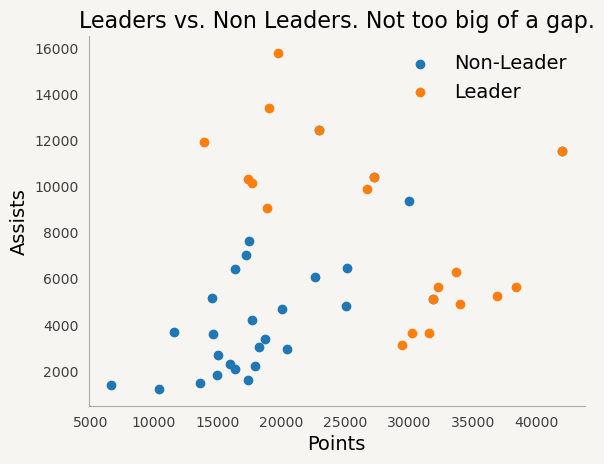

In [54]:


top10 = np.array([sublist for sublist in minutesPointsAssists if sublist[0] > threshold])
leaders = np.array(minutesPointsAssistsLeaders)
fig, ax = plt.subplots()

ax.scatter(top10[:,1], top10[:,2], label="Non-Leader")
ax.scatter(leaders[:,1], leaders[:,2], label="Leader")
tidy_axes(ax)

ax.set_xlabel("Points", fontsize=labelsize)
ax.set_ylabel("Assists", fontsize=labelsize)
ax.set_title("Leaders vs. Non Leaders. Not too big of a gap.", fontsize=titlesize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/pts_asts_scatter.png")
plt.show()

In [55]:
pointsArray = np.concatenate((top10[:,1], leaders[:,1]))
assistsArray = np.concatenate((top10[:,2], leaders[:,2]))

ptsAsts = pd.DataFrame(np.array([pointsArray, assistsArray]).T, columns=["Points", "Assists"])

# Normalize it
scaler = StandardScaler()
ptsAsts = pd.DataFrame(scaler.fit_transform(ptsAsts), columns=ptsAsts.columns)


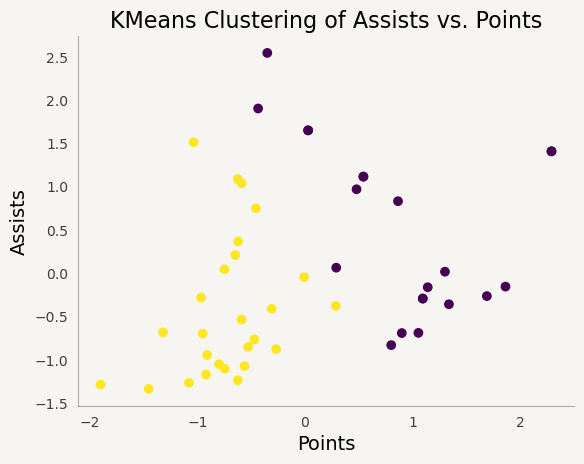

In [56]:
fig, ax = plt.subplots()


kmeans = KMeans(n_clusters=2)
kmeans.fit(ptsAsts)

ax.scatter(ptsAsts["Points"], ptsAsts["Assists"], c=kmeans.labels_)

tidy_axes(ax)
ax.set_title("KMeans Clustering of Assists vs. Points", fontsize=titlesize)
ax.set_xlabel("Points", fontsize=14)
ax.set_ylabel("Assists", fontsize=14)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/kmeans.png")
plt.show()

## Running just below this line because the KMEANS stuff takes forever to call API

## Look at the leaguedashplayers endpoint for all player stats over the 2023-2024 year
### This data will be used for DBSCAN and Hierarchecal clustering

In [14]:
# Get player stats for the previous season
df = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24').get_data_frames()[0]

# All quantitative variables
features = [
     'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
    'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']

X = df[features].dropna()

# Add a pseudolabel for starters
df['STARTER'] = df["MIN"]/df["GP"] >= 25

In [23]:
# Show head of data
df.to_csv("../data/module2_data/leaguedashplayerstats.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PLAYER_ID              572 non-null    int64  
 1   PLAYER_NAME            572 non-null    object 
 2   NICKNAME               572 non-null    object 
 3   TEAM_ID                572 non-null    int64  
 4   TEAM_ABBREVIATION      572 non-null    object 
 5   AGE                    572 non-null    float64
 6   GP                     572 non-null    int64  
 7   W                      572 non-null    int64  
 8   L                      572 non-null    int64  
 9   W_PCT                  572 non-null    float64
 10  MIN                    572 non-null    float64
 11  FGM                    572 non-null    int64  
 12  FGA                    572 non-null    int64  
 13  FG_PCT                 572 non-null    float64
 14  FG3M                   572 non-null    int64  
 15  FG3A  

In [29]:
# Snipping tool on this cell for image of cleaned data
X.to_csv("../data/module2_data/cleaned_data_DBSCAN.png")
X.head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,54,121,0.446,13,50,0.260,15,23,0.652,14,36,50,20,14,10,3,8,22,13,136,18
1,83,196,0.423,69,169,0.408,17,19,0.895,9,55,64,30,12,9,4,3,49,20,252,50
2,18,62,0.290,10,39,0.256,2,2,1.000,2,16,18,5,8,1,2,3,6,1,48,-51
3,398,716,0.556,40,138,0.290,177,269,0.658,174,297,471,259,105,56,45,57,142,223,1013,423
4,186,417,0.446,84,217,0.387,58,63,0.921,23,100,123,140,53,42,6,20,125,65,514,85


## DBSCAN clustering via PCA

In [30]:
# PCA object on scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

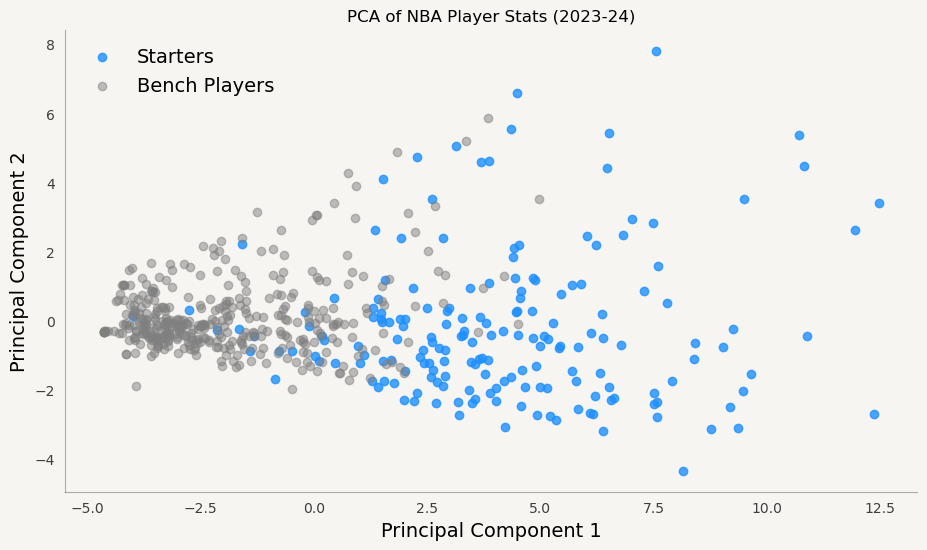

[0.62807593 0.10534739]
0.7334233189081657


In [31]:
# Create a mask based on STARTER feature
starter_mask = df['STARTER'].values
nonstarter_mask = ~starter_mask

# Plot PCA with different colors
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

ax.scatter(X_pca_2[starter_mask, 0], X_pca_2[starter_mask, 1], alpha=0.8, label='Starters', color='dodgerblue')
ax.scatter(X_pca_2[nonstarter_mask, 0], X_pca_2[nonstarter_mask, 1], alpha=0.5, label='Bench Players', color='gray')

ax.set_title('PCA of NBA Player Stats')
ax.set_xlabel('Principal Component 1', fontsize=labelsize)
ax.set_ylabel('Principal Component 2', fontsize=labelsize)
tidy_axes(ax)
ax.legend(loc=2, frameon=False, fontsize=labelsize)
plt.show()


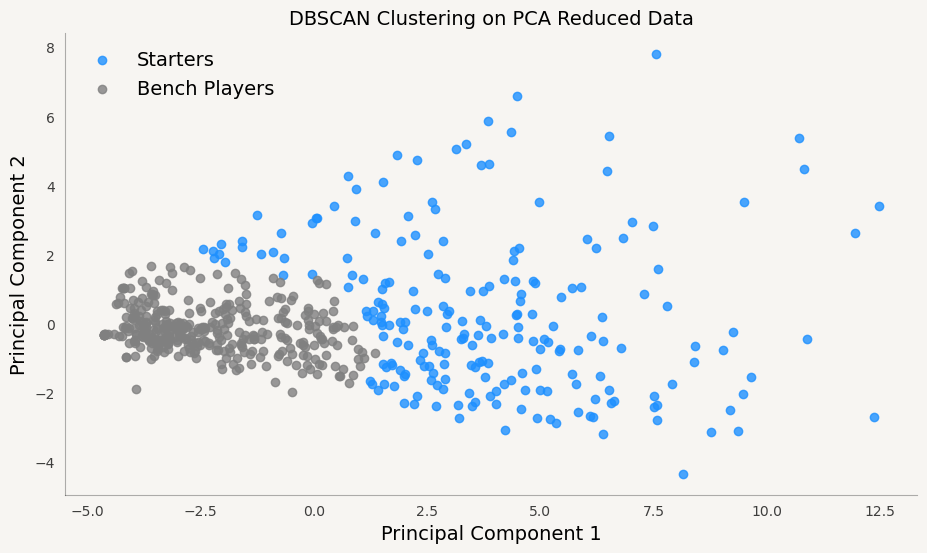

0.8706293706293706


In [99]:
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

# DBSCAN
clustering = DBSCAN(eps=1, min_samples=45).fit(X_pca_2)
labels = clustering.labels_

# Plot points by cluster
unique_labels = np.unique(labels)
for label in unique_labels:
    mask = labels == label
    ax.scatter(X_pca_2[mask, 0], X_pca_2[mask, 1],  alpha=0.8,
               label="Bench Players" if label != -1 else "Starters",
               c='dodgerblue' if label == -1 else "grey")

ax.set_title('DBSCAN Clustering on PCA Reduced Data', fontsize=labelsize)
ax.set_xlabel('Principal Component 1', fontsize=labelsize)
ax.set_ylabel('Principal Component 2', fontsize=labelsize)
tidy_axes(ax)
ax.legend(fontsize=labelsize, frameon=False, loc=2)
plt.savefig("../images/module2_images/dbscan.png")
plt.show()

# See how accurate clustering is
cluster_accuracy = (df['STARTER'] == -1*labels).sum()/len(df)
print(cluster_accuracy)

### Hierarchical Clustering

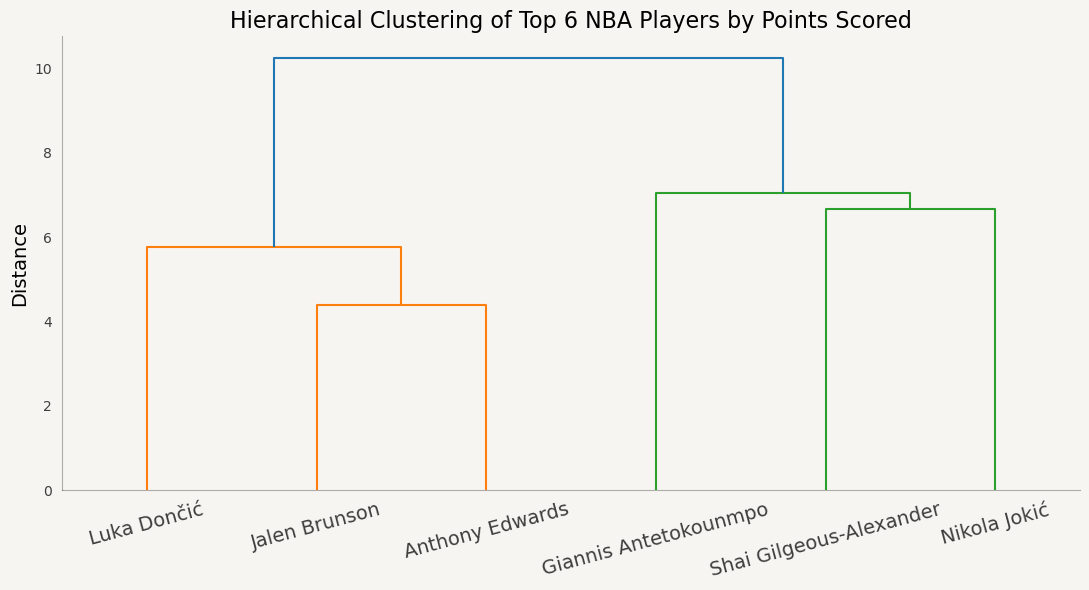

In [125]:
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

top_scorers_df = df.sort_values(by='PTS', ascending=False).head(6)

X_top_scorers = top_scorers_df[features].dropna()
X_top_scaled = scaler.fit_transform(X_top_scorers)

# Use scaled data
linked = linkage(X_top_scaled, method='ward')

# Plot dendrogram
dendrogram(linked, labels=top_scorers_df['PLAYER_NAME'].values, leaf_rotation=15, leaf_font_size=labelsize)
ax.set_title('Hierarchical Clustering of Top 6 NBA Players by Points Scored', fontsize=titlesize)
ax.set_ylabel('Distance', fontsize=labelsize)
plt.tight_layout()
tidy_axes(ax)
plt.savefig("../images/module2_images/hierarchical_clustering.png")
plt.show()


In [119]:
X_top_scorers["NAME"] = top_scorers_df['PLAYER_NAME'].values
X_top_scorers.to_csv("../data/module2_data/top_6_scorers.csv")
X_top_scorers

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NAME
372,804,1652,0.487,284,744,0.382,478,608,0.786,59,588,647,686,282,99,38,50,149,477,2370,319,Luka Dončić
501,796,1487,0.535,95,269,0.353,567,649,0.874,65,350,415,465,162,150,67,77,184,480,2254,613,Shai Gilgeous-Alexander
184,837,1369,0.611,34,124,0.274,514,782,0.657,196,645,841,476,250,87,79,90,210,604,2222,339,Giannis Antetokounmpo
233,790,1648,0.479,211,526,0.401,421,497,0.847,43,235,278,519,186,70,13,64,144,480,2212,512,Jalen Brunson
434,822,1411,0.583,83,231,0.359,358,438,0.817,223,753,976,708,237,108,68,68,194,426,2085,682,Nikola Jokić
29,718,1558,0.461,190,532,0.357,423,506,0.836,52,378,430,405,241,101,42,56,141,336,2049,432,Anthony Edwards
